## Nanoprisms model
* pure python model using Lebedev quadrature
* SASView file model is `nanoprisms.py`


### Lebedev library
* need pylebedev library installed in the python environnement
https://pypi.org/project/pylebedev/ 
* installation using: `pip install pylebedev` in a terminal


In a global python environnement, pylebedev is installed here:
* C:\Users\Administrateur\AppData\Local\Programs\Python\Python310\Lib\site-packages\pylebedev

Before using the model with Sasview GUI, copy the pylebedev folder here:
* C:\SasView-6.0.0\pylebedev

### prismformfactors library
Installation here :
* https://github.com/jules-marcone/prismformfactors
* In a global python environnement:
C:\Users\Administrateur\AppData\Local\Programs\Python\Python310\Lib\site-packages\prisformfactors
* Before using the model with Sasview GUI, copy the library here:     
C:\SasView-6.0.0\prismformfactors

#### modifications in the prismfactors library:
* file `control.py ` has been renamed to `controls.py ` in the library. ( to avoid some conflicts with SASView ... )
* updated init file `__init__.py`
* updated `average.py ` and `vizualise.py ` files 

### location of the python model file:
* in a global environnement, put it directly here:
C:\Users\Administrateur\AppData\Local\Programs\Python\Python310\Lib\site-packages\sasmodels\models
* For usage with SASView GUI, put it in your user plugin folder here:
C:\Users\Administrateur\.sasview\plugin_models


#### Possible improvements of the model:
Code in: `nanoprisms.py`
* option Iq.vectorise=False 
* find a way to code the intensity allowing option Iq.vectorized= True ???
* option is coded here in SASView: \sasmodels\kernelpy.py

### Beginning of code

import all the packages
* need installation of sasmodels, sasdata, bumps in your python environnement

In [1]:
import numpy as np

# import sasmodels
import sasmodels
import sasmodels.core
import sasmodels.data
import sasmodels.bumps_model

import sasdata
from sasdata.dataloader.loader import Loader

from sasmodels.core import load_model
from sasmodels.bumps_model import Model, Experiment
from sasmodels.data import load_data, empty_data1D, plot_data

import bumps
import bumps.fitters
import bumps.names
import bumps.fitproblem


import os
#import periodictable
#import periodictable.nsf
import tol_colors as tc # colorblind safe color palettes


"""
import matplotlib.pyplot and set custom default settings for plots
"""
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

plt.rc('font', size=14) # default fontsize
plt.rc('axes', titlesize=16)
plt.rc('axes', labelsize=16)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('legend', fontsize=14)
plt.rc('legend', title_fontsize=14)
plt.rc('figure', titlesize=18)
plt.rc("figure", figsize=(5,5))
plt.rc("lines", linewidth=3)


# use colorblind safe colors:
plt.rc('axes', prop_cycle=plt.cycler('color', list(tc.tol_cset('muted'))))
try:
    plt.cm.register_cmap('tc_iridescent', tc.tol_cmap('iridescent'))
except:
    pass
plt.rc('image', cmap='tc_iridescent')

C:\Users\Administrateur\AppData\Local\Temp\ipykernel_54232\1856067786.py:33: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg')


Load a 1D data file

* 70.dat is a data set from gold octahedrons dilute suspension (Form Factor)
* load the data from an example .dat file into a numpy array
* transform the numpy array into a suitable 1D data set using `sasmodels.data.Data1D`
* possiblity to reduce the number of data points by slicing

2373
238


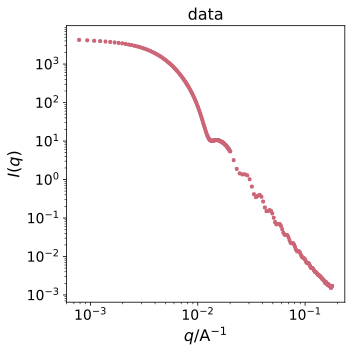

In [2]:
filename='./test_data/e6_output_full.dat' # data from JAC nanoprisms paper 
data_np = np.loadtxt(filename, skiprows=40)

number_of_data=data_np.shape[0] #total number of data points in the file
print(number_of_data)

slicing_step=10 # step of slicing 

# new error bars: 10 % of intensity values
coeff=0.1
#data = sasmodels.data.Data1D(x=data_np[:,0], y=data_np[:,1], dy=data_np[:,2])
data = sasmodels.data.Data1D(x=data_np[0:number_of_data:slicing_step,0], 
                             y=data_np[0:number_of_data:slicing_step,1], 
                             dy=coeff*data_np[0:number_of_data:slicing_step,1])

number_of_data_new=data.x.shape[0]
print(number_of_data_new)

sasmodels.data.plot_data(data)

Save the data file after applying slicing and modifying error bars

In [3]:
newfilename='./test_data/e6_output_new.dat' # data after slicing and error bars correction 

with open(newfilename, "w") as f:
    f.write("raw data file is: e6_output_full.dat\n")
    f.write("number of data points: \t"+str(number_of_data_new)+"\n")

with open(newfilename, "a") as fa:
    for i in range(0,number_of_data_new):
        line_to_write=str(data.x[i])+"\t"+str(data.y[i])+"\t"+str(data.dy[i])+"\n"
        fa.write(line_to_write)


### Use the model: theory only

### Fit with the model 
* create the computation `kernel` selecting the `octa_general` model
* create the `modelfit` interfaced with bump module
* create the `experiment`, containing both data and model

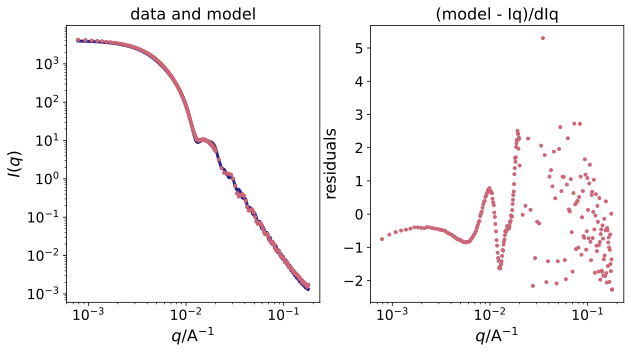

In [10]:
kernel = sasmodels.core.load_model("nanoprisms")
params = {
    "background": 0.001,
    "scale": 0.3,
    "n_sides" : 5,
    "R_ave": 300,
    "L":1170,
    "n_order":20,
    "R_ave_pd_type": 'gaussian', #type of polydispersity function
    "R_ave_pd": 0.08, #polydispersity
    "R_ave_pd_n": 10, #number of steps in polydispersity
    "R_ave_pd_nsigma": 3, #range as multiple of sigma

#    "L_pd_type": 'gaussian', #type of polydispersity function
#    "L_pd": 0.05, #polydispersity
#    "L_pd_n": 10, #number of steps in polydispersity
#    "L_pd_nsigma": 3, #range as multiple of sigma

}
modelfit = sasmodels.bumps_model.Model(kernel, **params)
experiment = sasmodels.bumps_model.Experiment(data=data, model=modelfit)

plt.figure(figsize=(10,5))
experiment.plot()

step 1 cost 2.761(20)
                                       L .|........       1170 in (1100,1500)
                                   R_ave ....|.....        300 in (250,350)
                              background ....|.....      0.001 in (0.0005,0.0015)
                                   scale ..|.......        0.3 in (0.2,0.6)
step 2 cost 2.309(20)
step 3 cost 2.305(20)
                                       L .|........    1171.04 in (1100,1500)
                                   R_ave .....|....    302.344 in (250,350)
                              background .......|.. 0.00125527 in (0.0005,0.0015)
                                   scale ..|.......   0.299398 in (0.2,0.6)
step 4 cost 2.303(20)
step 5 cost 2.300(20)
                                       L .|........    1172.13 in (1100,1500)
                                   R_ave .....|....    302.472 in (250,350)
                              background .......|.. 0.00125609 in (0.0005,0.0015)
                              

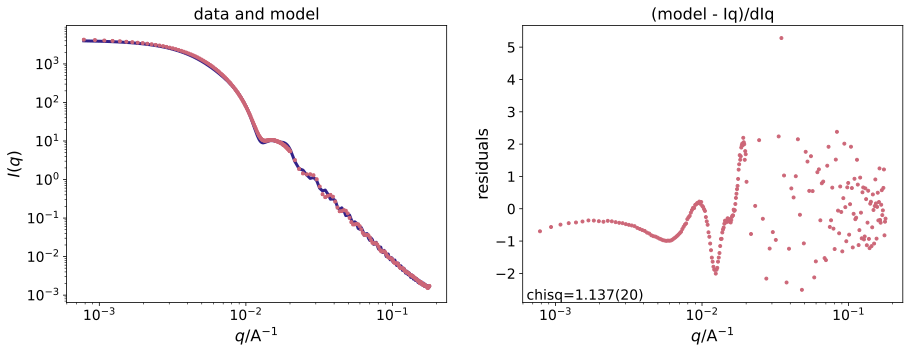

In [11]:
#list of the fiting parameters with their fiting range
modelfit.scale.range(0.2, 0.6)
modelfit.background.range(0.0005, 0.0015)
modelfit.R_ave.range(250, 350)
modelfit.L.range(1100,1500)
#modelfit.R_ave_pd.range(0.04,0.08)

problem = bumps.fitproblem.FitProblem(experiment)

results = bumps.fitters.fit(problem, 
                            method='lm', 
                            steps=20, 
                            ftol=1.5e-06, 
                            xtol=1.5e-06, 
                            verbose=True)

plt.figure(figsize=(15,5))
problem.plot()
print(problem.summarize())

The current value of all parameters can always be called using `model.state()`:

In [ ]:
modelfit.state()

{'scale': 0.2730157605033864,
 'background': 0.001,
 'sld': 126.0,
 'sld_solvent': 9.4,
 'n_sides': 5,
 'R_ave': 303.75974438427374,
 'R_ave_pd': 0.08,
 'R_ave_pd_n': 10,
 'R_ave_pd_nsigma': 3,
 'L': 1049.3562837856794,
 'L_pd': 0.0,
 'L_pd_n': 35.0,
 'L_pd_nsigma': 3.0,
 'n_order': 20,
 'up_frac_i': 0.0,
 'up_frac_f': 0.0,
 'up_angle': 0.0,
 'up_phi': 0.0,
 'sld_M0': 0.0,
 'sld_mtheta': 0.0,
 'sld_mphi': 0.0,
 'sld_solvent_M0': 0.0,
 'sld_solvent_mtheta': 0.0,
 'sld_solvent_mphi': 0.0,
 'R_ave_pd_type': 'gaussian',
 'L_pd_type': 'gaussian'}

In [ ]:
print(problem.summarize())

                                       L .......|..    1049.36 in (900,1100)
                                   R_ave .....|....     303.76 in (250,350)
                                R_ave_pd .........|       0.08 in (0.04,0.08)
                                   scale |.........   0.273016 in (0.2,1)


In [ ]:
results.x

array([1.04935628e+03, 3.03759744e+02, 8.00000000e-02, 2.73015761e-01])

In [ ]:
problem.labels()

['L', 'R_ave', 'R_ave_pd', 'scale']

In [ ]:
problem.fitness.model.state()

{'scale': 0.2730157605033864,
 'background': 0.001,
 'sld': 126.0,
 'sld_solvent': 9.4,
 'n_sides': 5,
 'R_ave': 303.75974438427374,
 'R_ave_pd': 0.08,
 'R_ave_pd_n': 10,
 'R_ave_pd_nsigma': 3,
 'L': 1049.3562837856794,
 'L_pd': 0.0,
 'L_pd_n': 35.0,
 'L_pd_nsigma': 3.0,
 'n_order': 20,
 'up_frac_i': 0.0,
 'up_frac_f': 0.0,
 'up_angle': 0.0,
 'up_phi': 0.0,
 'sld_M0': 0.0,
 'sld_mtheta': 0.0,
 'sld_mphi': 0.0,
 'sld_solvent_M0': 0.0,
 'sld_solvent_mtheta': 0.0,
 'sld_solvent_mphi': 0.0,
 'R_ave_pd_type': 'gaussian',
 'L_pd_type': 'gaussian'}